# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-05*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
var = 'RH'
month = "Sep"

low_years = np.array([2016,2015,2014])
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]

avg_low  = average_data(low_files, var)
avg_high = average_data(high_files, var)

lon = avg_low.longitude
lat = avg_low.latitude

In [3]:
cities = ['Guangzhou', 'Foshan', 'Dongguan', 'Shenzhen',
          'Zhongshan', 'Zhuhai', 'Zhaoqing', 'Jiangmen',
          'Huizhou']

df_low = {}
df_high = {}
for city in cities:
    shpvar = eval(f'shp_{city}_adm')
    shp = gpd.read_file(shpvar)

    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))

    masked_low  = avg_low.where(mask_da)
    mean_low    = masked_low.mean(dim=('x','y'),skipna=True)
    masked_high = avg_high.where(mask_da)
    mean_high   = masked_high.mean(dim=('x','y'),skipna=True)

    df_low[city] = mean_low
    df_high[city] = mean_high
    print(f'Complete {city}')

Complete Guangzhou
Complete Foshan
Complete Dongguan
Complete Shenzhen
Complete Zhongshan
Complete Zhuhai
Complete Zhaoqing
Complete Jiangmen
Complete Huizhou


## 绘制热力图

查看各城市均值大小排序

In [4]:
df_city = pd.DataFrame(
    index=cities,
    data={'Low':[df_low[city].mean().values for city in cities],
          'High':[df_high[city].mean().values for city in cities]}
)

In [5]:
sorted_df = df_city.sort_values(by='Low',ascending=False)
sorted_df

,Low,High
Huizhou,80.16755,70.26143
Jiangmen,79.33183,74.554535
Zhuhai,78.70471,74.42503
Zhaoqing,77.64802,67.32832
Guangzhou,74.32278,64.57353
Shenzhen,73.11665,65.28227
Zhongshan,72.499405,66.127884
Foshan,69.37587,61.338497
Dongguan,68.0466,59.100636


In [6]:
sorted_df = df_city.sort_values(by='High',ascending=False)
sorted_df

,Low,High
Jiangmen,79.33183,74.554535
Zhuhai,78.70471,74.42503
Huizhou,80.16755,70.26143
Zhaoqing,77.64802,67.32832
Zhongshan,72.499405,66.127884
Shenzhen,73.11665,65.28227
Guangzhou,74.32278,64.57353
Foshan,69.37587,61.338497
Dongguan,68.0466,59.100636


热力图城市排序按照high的排序

In [17]:
# 排序2：按照纬度从北向南
city_list = ['Zhaoqing','Huizhou','Guangzhou','Foshan',
             'Dongguan','Shenzhen','Zhongshan','Jiangmen',
             'Zhuhai']

thermal_low = np.array(
 np.array([df_low[city].resample(time='D').mean() for city in city_list])
)
thermal_high = np.array(
 np.array([df_high[city].resample(time='D').mean() for city in city_list])
)
thermal_low.shape

(9, 30)

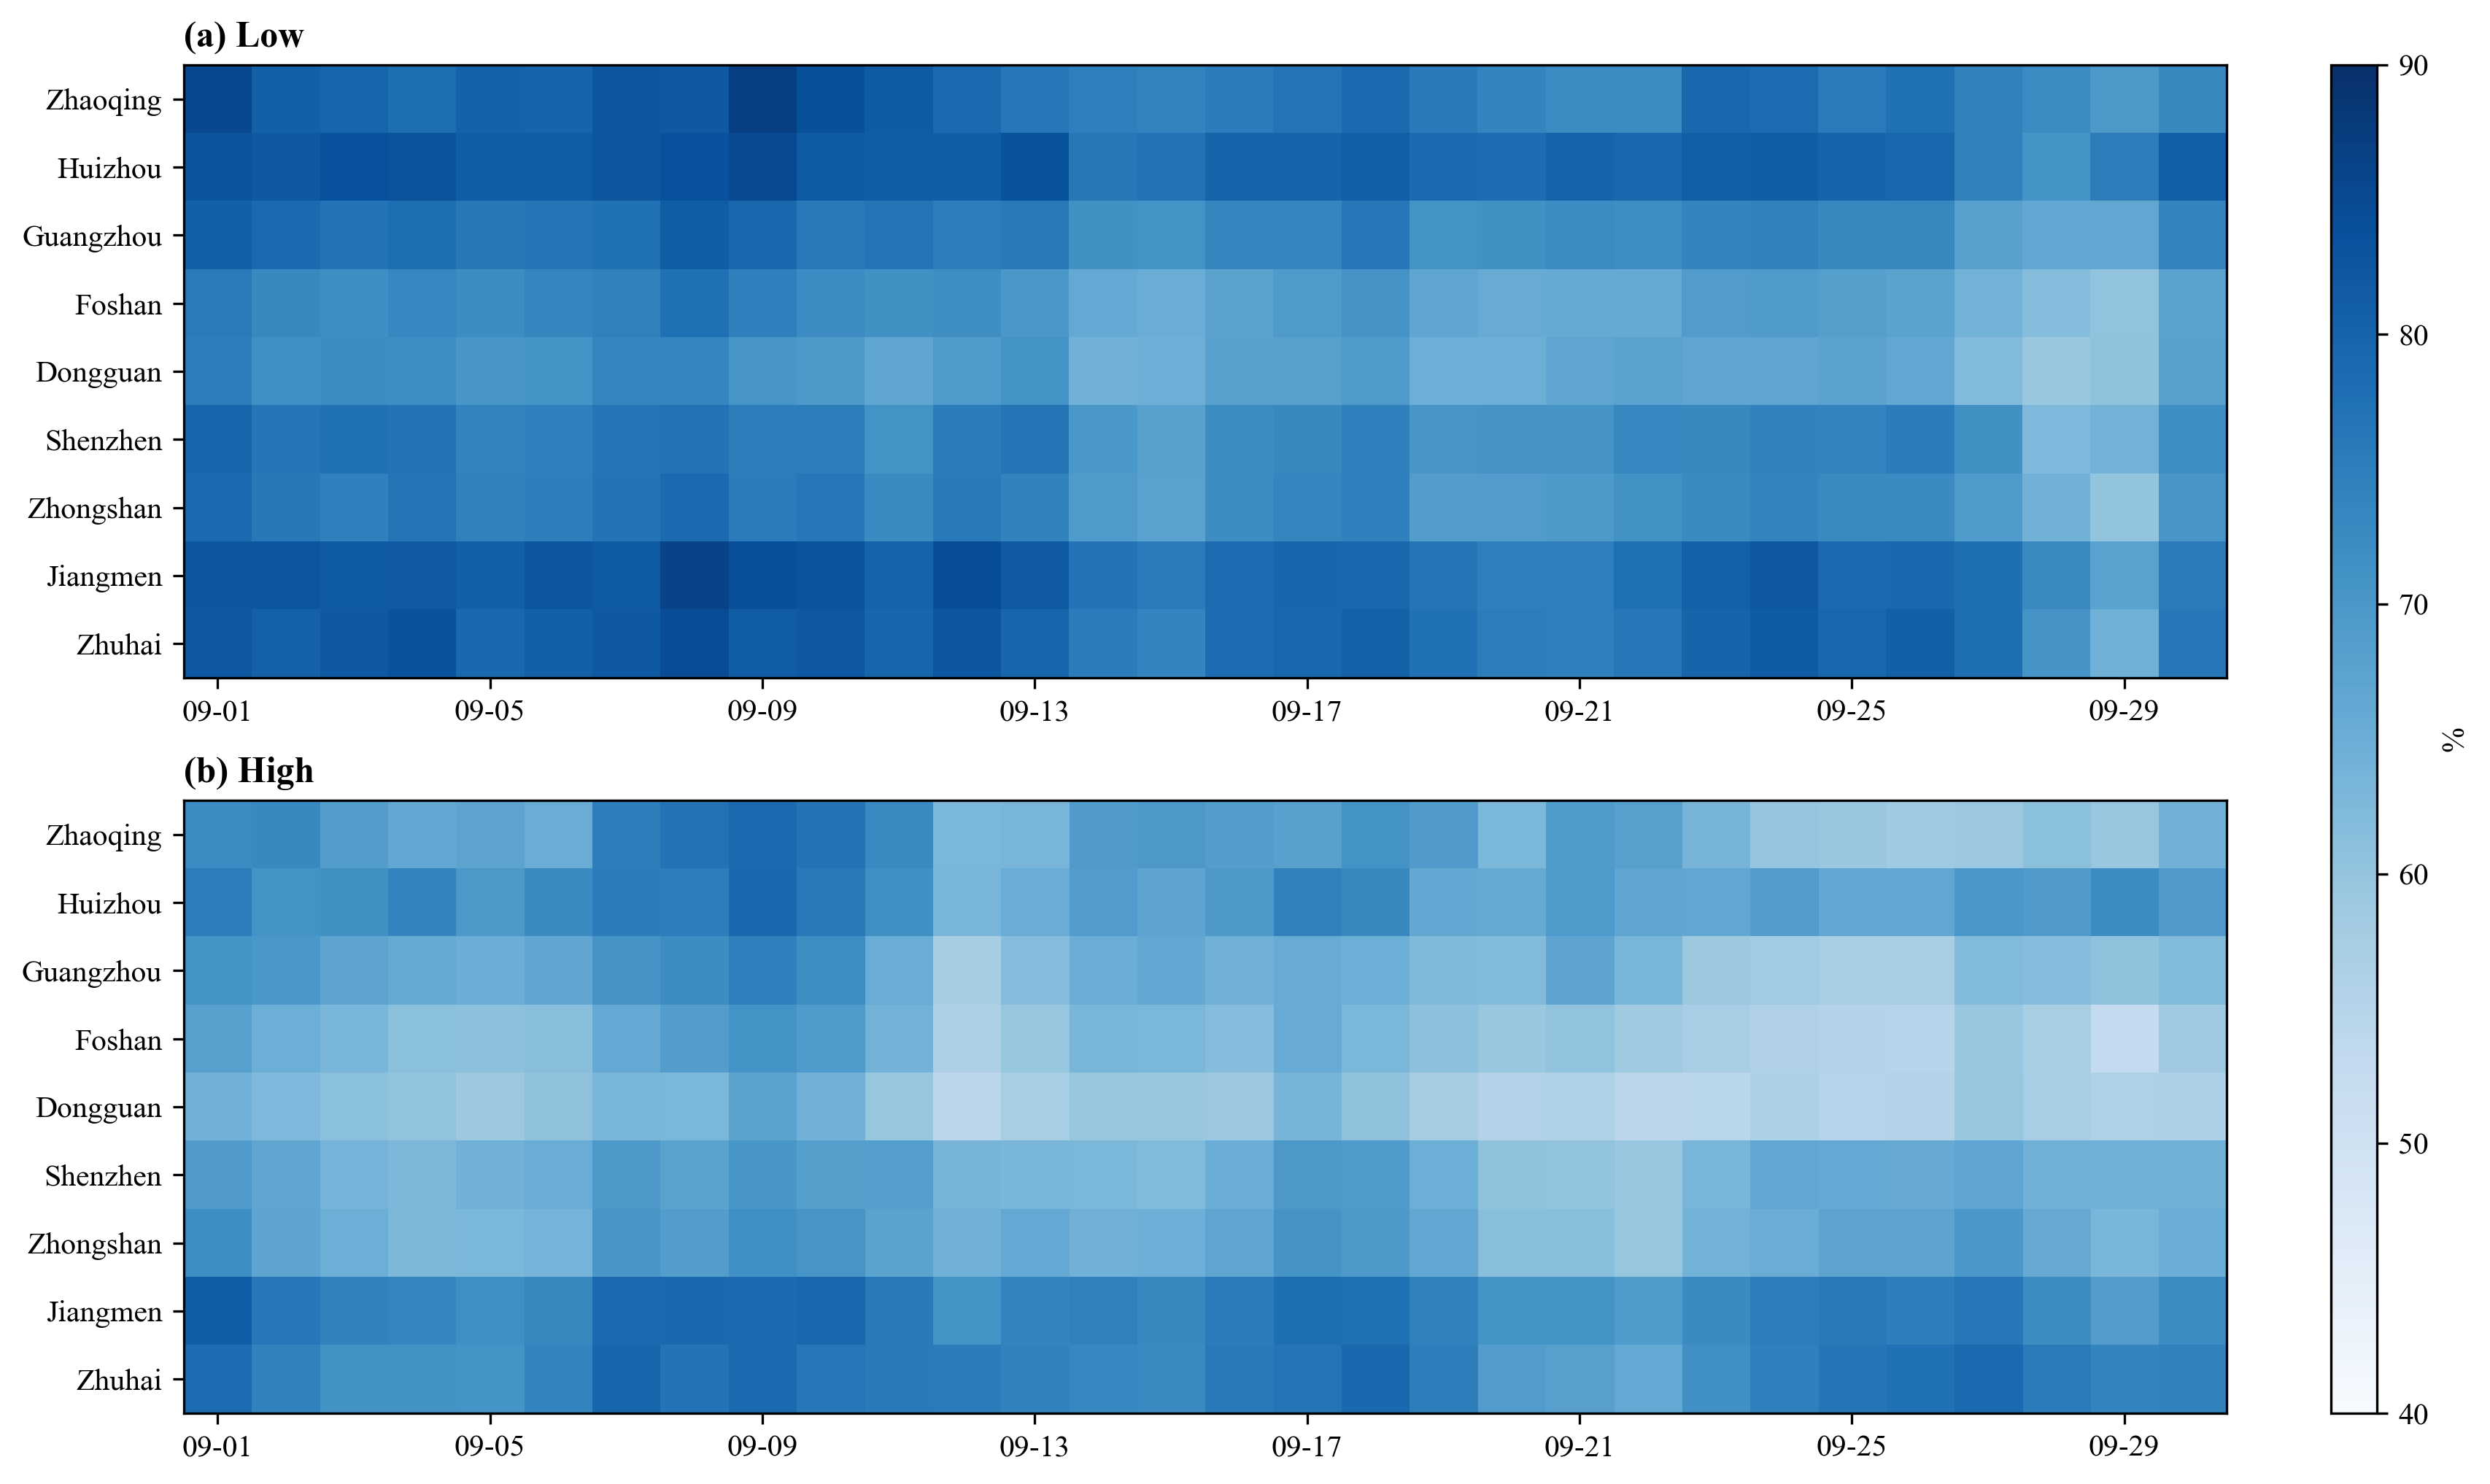

In [18]:
cmin = 40
cmax = 90

fig = plt.figure(figsize=(14, 8),dpi=300)
ax = fig.subplots(2,1)

ci = ax[0].imshow(thermal_low, vmin=cmin,vmax=cmax,cmap='Blues')
ci = ax[1].imshow(thermal_high, vmin=cmin,vmax=cmax,cmap='Blues')

ax[0].set_title('(a) Low', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
ax[1].set_title('(b) High', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})

for ax in ax.flat:
    ax.set_xticks(np.arange(0,np.size(thermal_high,1),4))
    ax.set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
    ax.set_yticks(np.arange(len(city_list)))
    ax.set_yticklabels(city_list)

fig.subplots_adjust(right=0.9,hspace=0.2)
position = fig.add_axes([0.88, 0.11, 0.015, 0.77])
cbar = fig.colorbar(ci, cax=position)
cbar.set_ticks(np.arange(cmin,cmax+.1,10))
cbar.set_label('%')
plt.show()


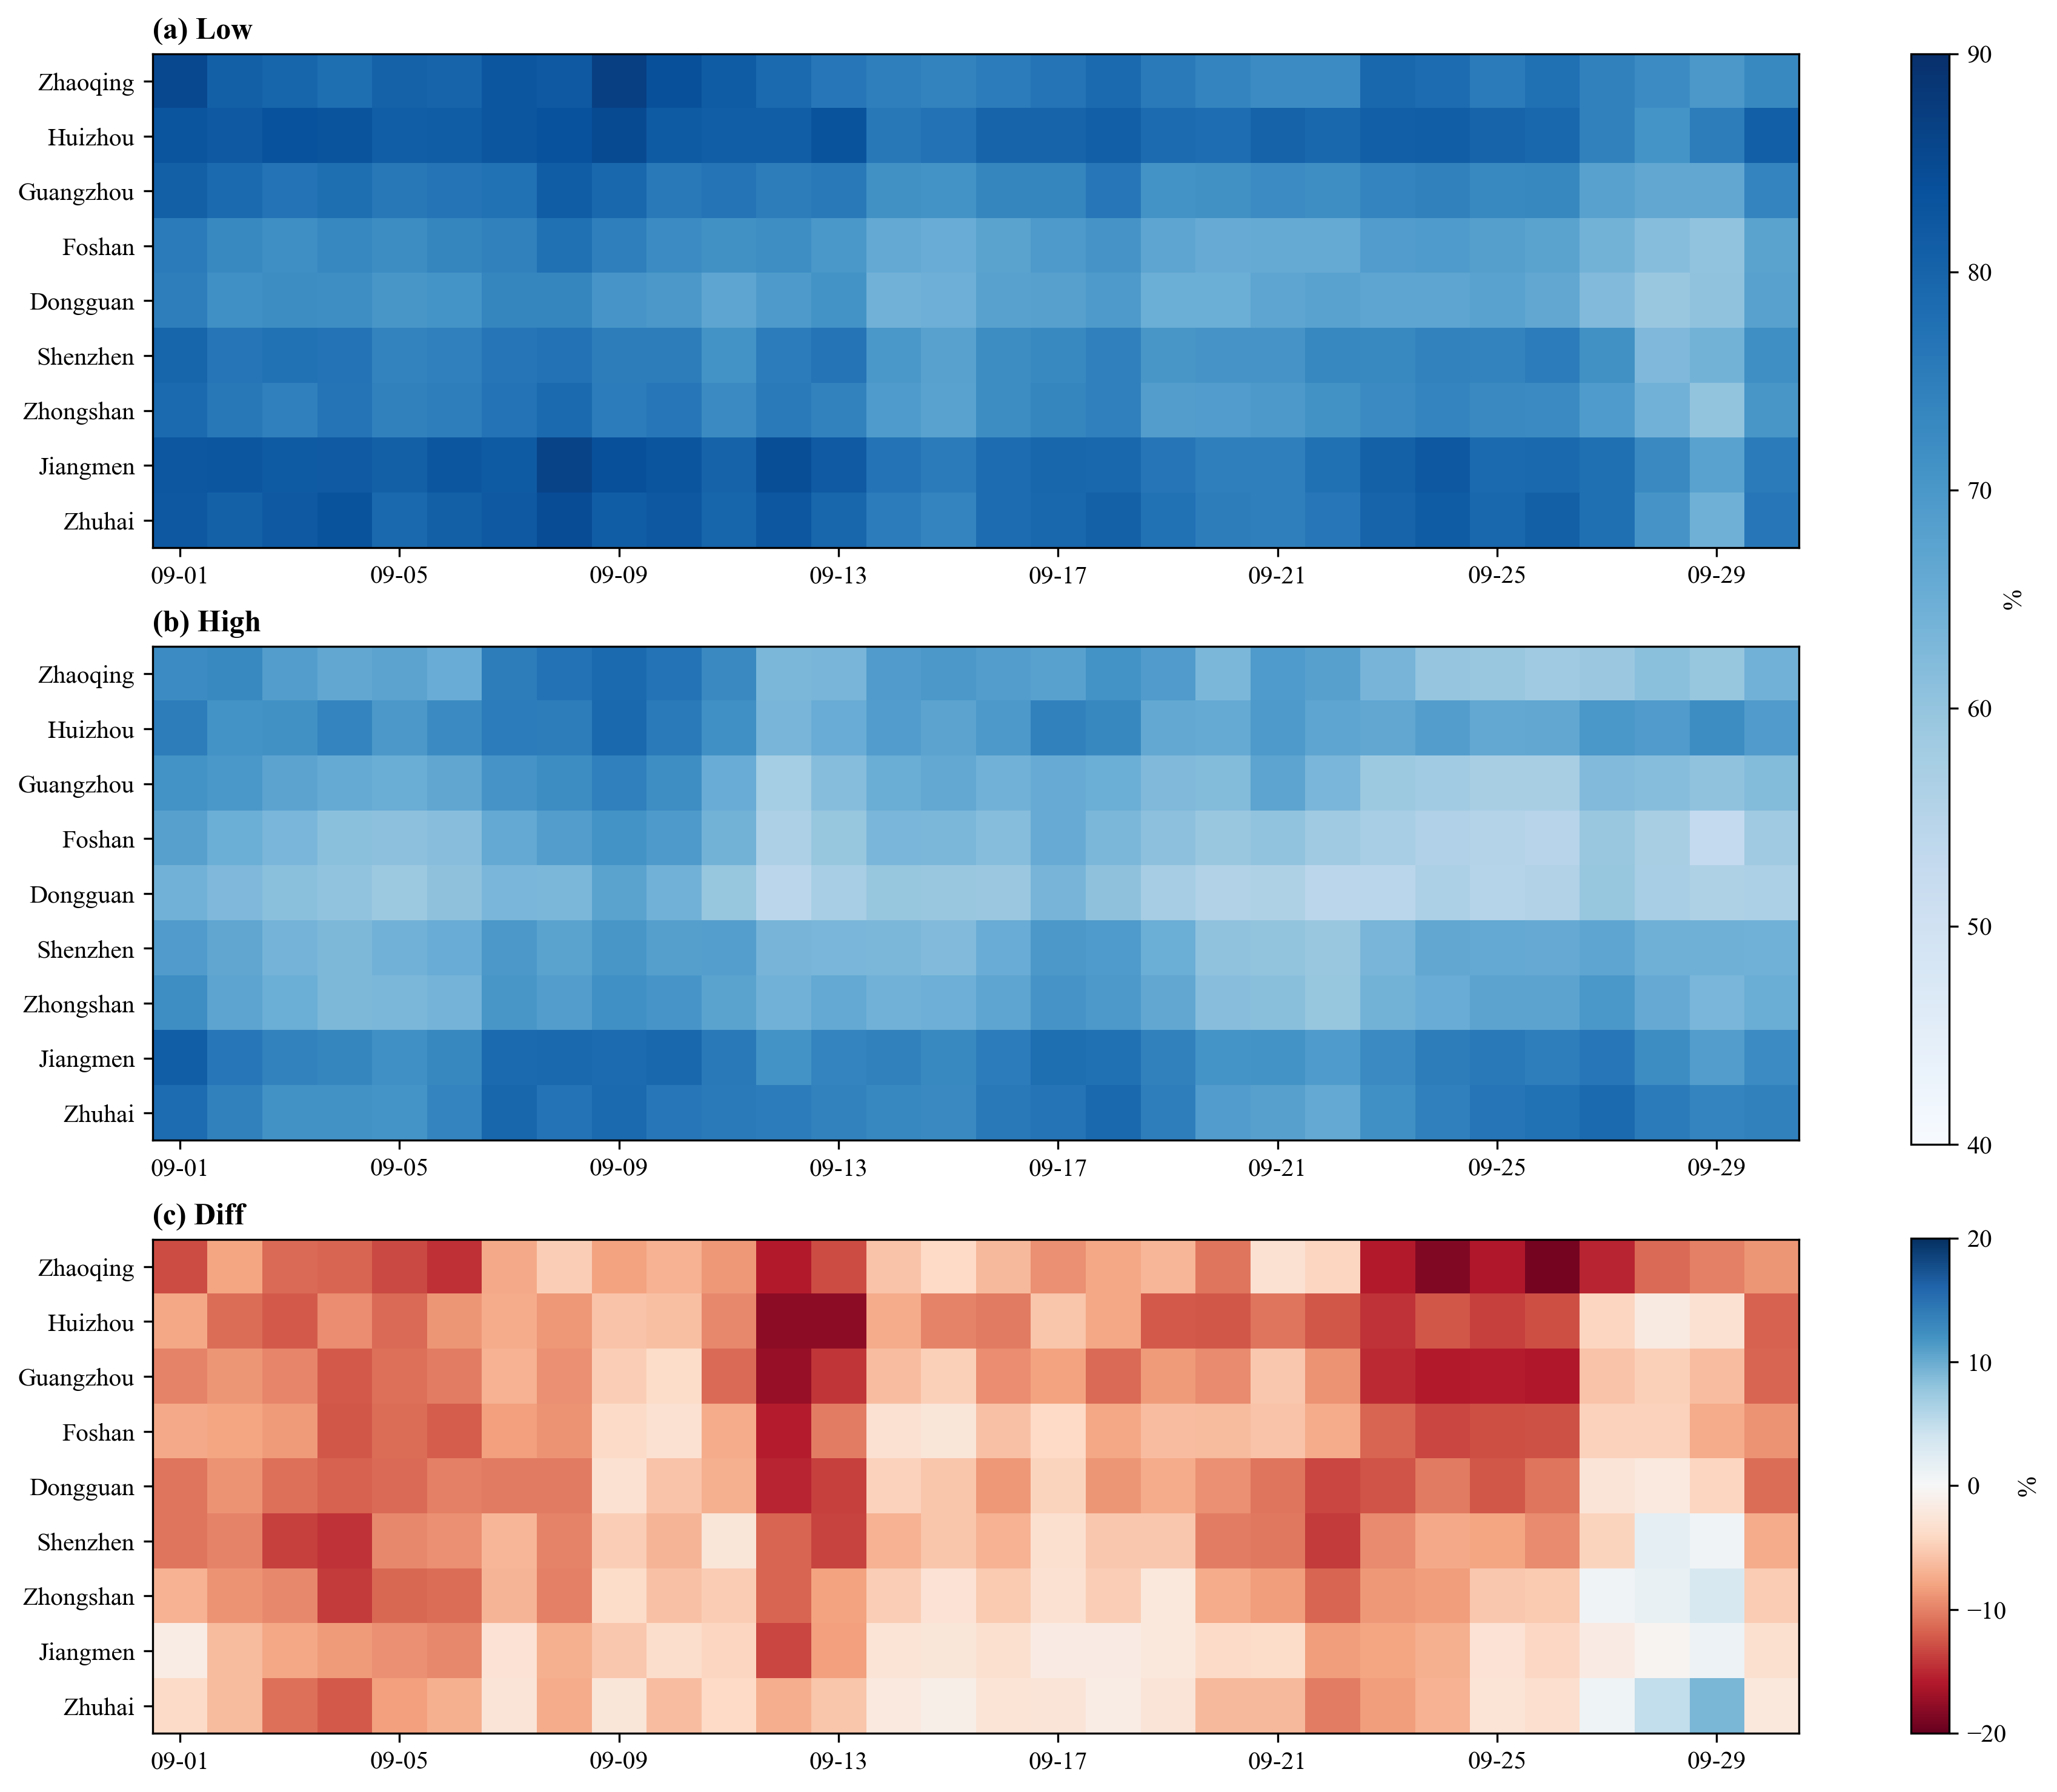

In [19]:
cmin = 40
cmax = 90
dmin = -20
dmax = 20

fig = plt.figure(figsize=(14, 12),dpi=300)
ax = fig.subplots(3,1)

ci = ax[0].imshow(thermal_low, vmin=cmin,vmax=cmax,cmap='Blues')
ci = ax[1].imshow(thermal_high, vmin=cmin,vmax=cmax,cmap='Blues')
cd = ax[2].imshow(thermal_high-thermal_low, vmin=dmin,vmax=dmax,cmap='RdBu')

ax[0].set_title('(a) Low', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
ax[1].set_title('(b) High', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
ax[2].set_title('(c) Diff', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})

for i in range(3):
    ax[i].set_xticks(np.arange(0,np.size(thermal_high,1),4))
    ax[i].set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
    ax[i].set_yticks(np.arange(len(city_list)))
    ax[i].set_yticklabels(city_list)

fig.subplots_adjust(right=0.9,hspace=0.2)

position1 = fig.add_axes([0.88, 0.38, 0.015, 0.5])
cbar1 = fig.colorbar(ci, cax=position1)
cbar1.set_ticks(np.arange(cmin,cmax+.1,10))
cbar1.set_label('%')

position2 = fig.add_axes([0.88, 0.11, 0.015, 0.227])
cbar2 = fig.colorbar(cd, cax=position2)
cbar2.set_ticks(np.arange(dmin,dmax+.1,10))
cbar2.set_label('%')
plt.show()
